<a id='sec0'></a>
# Predictive annotation of quantification methods 3
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec4'><b>Classification for ms1_label_free</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import gensim
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

#### Loading data

In [3]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,quant_methods,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast, cancer, tissue, lysate, reduction, al...","[proteomic, datum, analysis, proteome, discove...","[current, prognostic, factor, insufficient, pr...",itraq,0,0,0,0,1,0
1,PXD000164,"[protein, extraction, catheter, biofilm, small...","[mass, spectrometric, analyse, the, tryptic, d...","[long, term, catheterization, lead, inevitably...",label free,0,0,0,0,0,1


#### Functions for classification tasks

In [17]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        t = np.linspace(0, 1, 10)
        ax1.plot(t, t, ls='--', lw=0.5, color='0.3')
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: Logistic Regr. (\'%s\')' % target_label)
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: Logistic Regr. (\'%s\')' % target_label)
            ax2.legend()

        fig.tight_layout()
    return

<a id='sec4'></a>
## ms1_label_free

#### Feature Selection

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC 5-fold CV stats ==========
accuracy: 0.86 +/- 0.029
precision: 0.00 +/- 0.000
recall: 0.00 +/- 0.000
f1: 0.00 +/- 0.000
average_precision: 0.40 +/- 0.017
roc_auc: 0.75 +/- 0.034
Brier_loss: 0.12 +/- 0.021


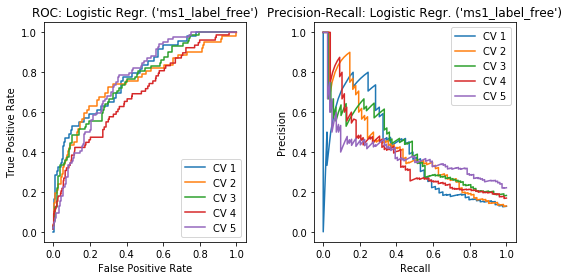

In [6]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=8)
initial_results = classifyCV(rfc, protocols_tfidf, df.ms1_label_free,
    name='RFC', n_splits=5, num_terms=22736)
summarize_results(initial_results, clf_label='RFC', target_label='ms1_label_free')

In [7]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

(22736, 741)

In [8]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    22736.000000
mean         0.000044
std          0.000366
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%          0.001426
max          0.018249
dtype: float64

In [9]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ >= 0.0001).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.0005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds4 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]
X4 = X0[:, new_inds4]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)
print('Shape X3   :', X4.shape)

Shape before: (2387, 22736)
Shape X1   : (2387, 718)
Shape X2   : (2387, 549)
Shape X3   : (2387, 357)
Shape X3   : (2387, 18)


In [10]:
# Check fraction of ms1_label_free class
print('Fraction with ms1_label_free = %.2f%%' % (100*df.ms1_label_free.sum()/len(df)))

Fraction with ms1_label_free = 14.45%


##### With RFC

In [20]:
rfcX1 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX4 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X2, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X4 = classifyCV(rfcX4, X4, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC with X1 10-fold CV stats ==========
accuracy: 0.86 +/- 0.039
precision: 0.57 +/- 0.501
recall: 0.05 +/- 0.064
f1: 0.08 +/- 0.108
average_precision: 0.49 +/- 0.089
roc_auc: 0.84 +/- 0.040
Brier_loss: 0.10 +/- 0.025
========== RFC with X2 10-fold CV stats ==========
accuracy: 0.86 +/- 0.041
precision: 0.70 +/- 0.483
recall: 0.06 +/- 0.070
f1: 0.10 +/- 0.119
average_precision: 0.50 +/- 0.106
roc_auc: 0.84 +/- 0.048
Brier_loss: 0.10 +/- 0.025
========== RFC with X3 10-fold CV stats ==========
accuracy: 0.86 +/- 0.041
precision: 0.60 +/- 0.516
recall: 0.05 +/- 0.072
f1: 0.09 +/- 0.121
average_precision: 0.50 +/- 0.097
roc_auc: 0.84 +/- 0.045
Brier_loss: 0.10 +/- 0.025
========== RFC with X4 10-fold CV stats ==========
accuracy: 0.86 +/- 0.036
precision: 0.54 +/- 0.206
recall: 0.16 +/- 0.068
f1: 0.24 +/- 0.081
average_precision: 0.43 +/- 0.080
roc_auc: 0.76 +/- 0.055
Brier_loss: 0.11 +/- 0.025


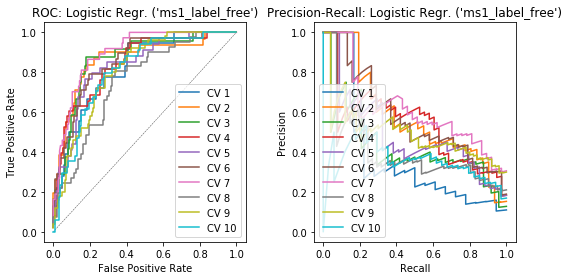

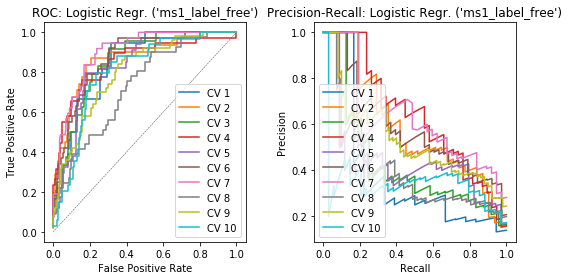

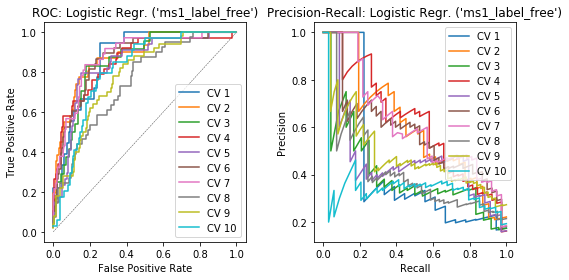

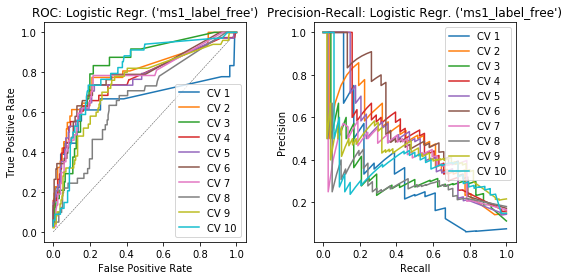

In [21]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X4, clf_label='RFC with X4', target_label='ms1_label_free', plot_result=True)

#### With LR

In [13]:
lrX1 = LogisticRegression(penalty='l1', C=1)
lrX2 = LogisticRegression(penalty='l1', C=1)
lrX3 = LogisticRegression(penalty='l1', C=1)
lrX4 = LogisticRegression(penalty='l1', C=1)

res_X1lr = classifyCV(lrX1, X1, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X4lr = classifyCV(lrX4, X4, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


========== LR with X1 10-fold CV stats ==========
accuracy: 0.85 +/- 0.033
precision: 0.48 +/- 0.340
recall: 0.05 +/- 0.031
f1: 0.09 +/- 0.045
average_precision: 0.41 +/- 0.093
roc_auc: 0.81 +/- 0.054
Brier_loss: 0.11 +/- 0.025
========== LR with X2 10-fold CV stats ==========
accuracy: 0.85 +/- 0.033
precision: 0.53 +/- 0.330
recall: 0.07 +/- 0.048
f1: 0.11 +/- 0.067
average_precision: 0.41 +/- 0.096
roc_auc: 0.81 +/- 0.057
Brier_loss: 0.11 +/- 0.024
========== LR with X3 10-fold CV stats ==========
accuracy: 0.85 +/- 0.035
precision: 0.52 +/- 0.330
recall: 0.07 +/- 0.053
f1: 0.12 +/- 0.077
average_precision: 0.41 +/- 0.098
roc_auc: 0.81 +/- 0.057
Brier_loss: 0.11 +/- 0.024
========== LR with X4 10-fold CV stats ==========
accuracy: 0.86 +/- 0.032
precision: 0.61 +/- 0.272
recall: 0.08 +/- 0.047
f1: 0.13 +/- 0.066
average_precision: 0.39 +/- 0.093
roc_auc: 0.75 +/- 0.052
Brier_loss: 0.11 +/- 0.024


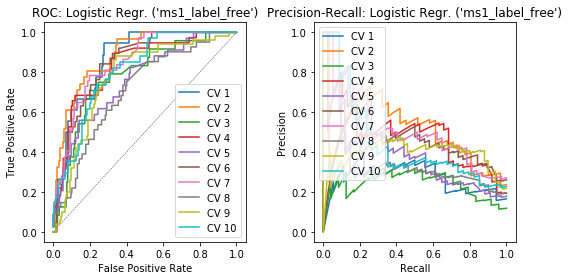

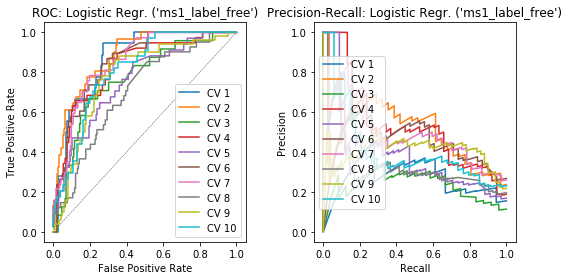

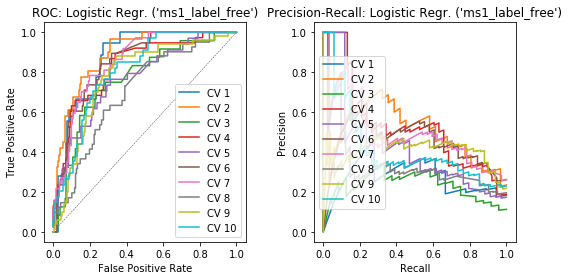

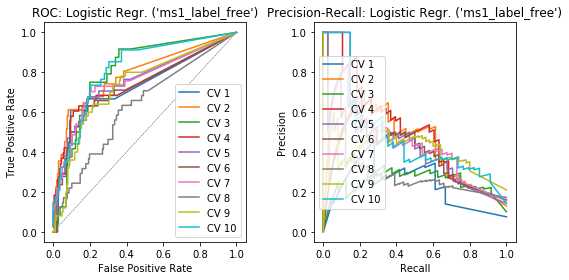

In [19]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X4lr, clf_label='LR with X4', target_label='ms1_label_free', plot_result=True)

In [15]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [16]:
inds_collection = [new_inds2, new_inds3]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

========== Feature Set 2 ==========
activation
analyze
available
cell
dataset
datum
factor
following
fractionation
gene
group
increase
independent
indicate
itraq
low
manuscript
ms
orbitrap
previously
protein
proteome
reduction
require
sample
set
spectra
subtype
top
unique
acetonitrile
allow
apply
artificial
bacterial
base
bsa
centrifugation
centrifuge
charge
cm
combine
compare
comparison
complement
contain
coomassie
cultures
database
dependent
digest
dry
dynamic
elution
eppendorf
equip
et
excise
false
fdr
file
final
fisher
five
formic
fragment
ge
gel
germany
gradient
identification
import
incubate
intensity
iodoacetamide
kda
least
linear
lock
mass
measure
medium
methanol
methionine
mix
modification
modify
nlc
nm
normalized
one
peak
pellet
percolator
point
profile
protease
quantification
quantify
ratio
reduce
remove
repeat
second
separate
separation
sequest
small
software
spectrometer
standard
step
store
supernatant
supplement
the
three
time
tip
tolerance
tris
two
vacuum
value
version
w